# Feature extraction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from main import PreProcessing, Statistics
import numpy as np
from scipy.stats import mode, median_abs_deviation, iqr, trim_mean, entropy, skew, kurtosis
from scipy.signal import welch, correlate
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

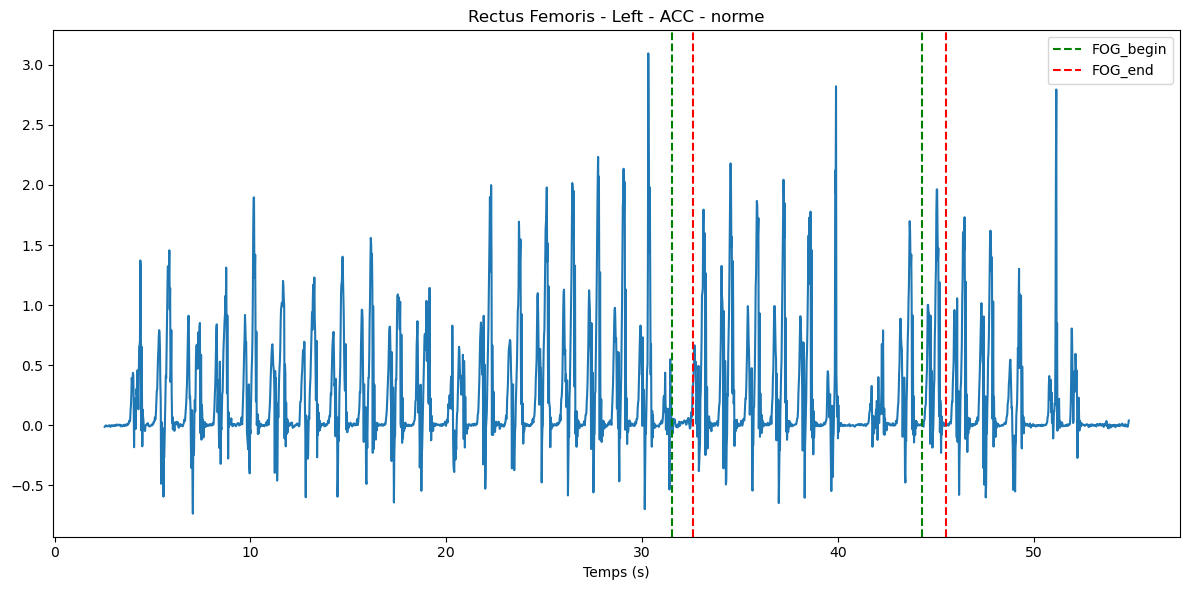

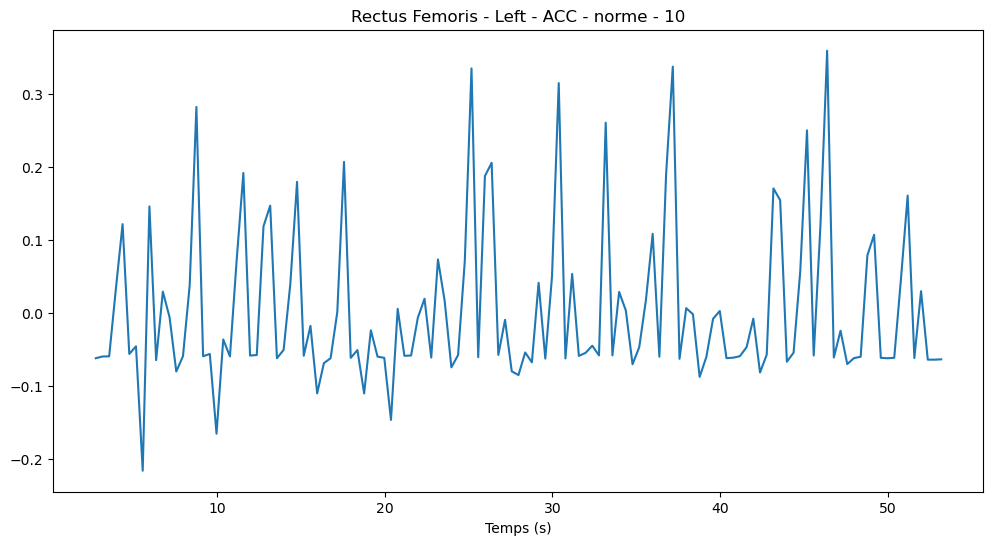

In [2]:
file_path = "C:/Users/antho/Documents/MEMOIRE_M2/CODE_STAGE_M2/DATA_FOG/LE_LIEVRE_Emmanuel_1971_03_19_LEEM1971/2023-05-26/2023-05-26_overlay_detectFOG/Video overlay 15.c3d"
# Définir les informations du patient
patient_id = 1234
date_de_naissance = "1963-06-23"
medicaments = "Traitement X"
# Instancier l'objet DetectFog
detector = PreProcessing(file_path)
detector.creation_json_grace_c3d(patient_id, date_de_naissance, medicaments)
detector.extract_data_interval()
detector.plot_data_FOG_start_end("Rectus Femoris", "Left", "ACC", "norme")
detector.normalize_data() 
detector.decoupage_en_fenetres()
detector.label_fenetre()
detector.association_label_fenetre_data()
data = detector.concat_label_fenetre_data()
detector.plot_data_FOG_start_end_final("Rectus Femoris", "Left", "ACC", "norme",10) # trouver une solution pour le temps

Attention le code le labelisation des fenêtre ne fonctionne pas quand il y a plusieurs FOG consécutifs ne moins de 1 ou 2 secondes

In [3]:
a = data["Rectus Femoris"]["Left"]["ACC"]["norme"]
a = a.iloc[:-1]
fog = data["FOG"]
print(fog)

{'debut': [31.50666618347168, 44.28666687011719], 'fin': [32.606666564941406, 45.526668548583984]}


# Extraction des caractéristiques

## 1. Domaine temporel

In [17]:
copie_a = a.copy()

a_sans_label = a.drop(columns=["label"])
a_sans_index = a_sans_label.iloc[:,1:]
a_moins_dernier_ligne = a_sans_label.iloc[:-1]
print(type(a_moins_dernier_ligne))
a_moins_dernier_ligne[1]

<class 'pandas.core.frame.DataFrame'>


0     -0.063129
1     -0.062885
2     -0.063301
3     -0.057445
4      0.017926
         ...   
120   -0.060055
121   -0.065343
122   -0.061367
123   -0.059134
124   -0.015557
Name: 1, Length: 125, dtype: float64

### a. Entropie

In [ ]:
# # Je ne comprend trop comment la formule est appliqué, car pour appliquer Shannon nous sommes censé avoir une 
# # des valeurs discrètess. Or, dans notre cas se sont des valeurs continues.

# def shannon_entropy(signal):
#     # Calculer l'histogramme des valeurs de la signal
#     hist, _ = np.histogram(signal, bins=256, density=True)
#     hist = hist[hist > 0]  # Supprimer les valeurs nulles pour éviter les erreurs de calcul

#     # Calculer l'entropie de Shannon
#     entropy = -np.sum(hist * np.log2(hist))

#     return entropy

# entropies = a_moins_dernier_ligne.apply(shannon_entropy, axis=1)

### b. Mode

In [40]:
# t = a_moins_dernier_ligne.transpose()


# def calculate_modes(data):
#     modes = []
#     for row in data:
#         unique_values, counts = np.unique(row, return_counts=True)
#         max_count_index = np.argmax(counts)
#         mode_value = unique_values[max_count_index]
#         mode_count = counts[max_count_index]
        
#         # Vérifier si le mode a une seule occurrence
#         if mode_count == 1:
#             modes.append(0)
#         else:
#             modes.append(mode_value)
#     return modes

# # Calculer les modes pour chaque ligne
# modes_per_row = calculate_modes(a_moins_dernier_ligne)

# print("Modes per Row:", modes_per_row)

'''Etant donné la précision de nos données, nous n'avons aucunes occurance et donc le mode ne sert à rien.'''

Modes per Row: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### c. median_abs_deviation

In [32]:
medmedian_abs_deviation = median_abs_deviation(a_moins_dernier_ligne, axis=1, nan_policy='omit')

##### Coef autorégression avec NaN

##### Validation croisée pour déterminer le meilleur ordre

In [18]:
fenetres = [np.array(window) for window in a_moins_dernier_ligne.values]


In [8]:
'''Nous allons effectuer une validation croisée temporelle pour déterminer l'ordre optimal du modèle 
d'autorégression pour chaque fenêtre de données.'''

'''L'ordre correspond au nombre de valeurs précédentes à utiliser pour prédire la valeur actuelle.'''

max_order = 9 # Ordre maximal du modèle AR à tester
best_orders = {}
best_mse = np.inf # Initialisation de l'erreur quadratique moyenne (MSE) minimale

# Définition de la stratégie de validation croisée temporelle
tscv = TimeSeriesSplit(n_splits=4)

# Parcours de chaque fenêtre
for i,fenetre in enumerate(fenetres):
    best_order = None
    best_mse = np.inf
    
    # Parcours des ordres possibles du modèle AR pour cette fenêtre
    for p in range(1, max_order + 1): # On commence à 1 car l'ordre 0 n'a pas de sens
        mse_scores = []
        
        # Parcours des plis de validation croisée
        for train_index, test_index in tscv.split(fenetre):
            train_data, test_data = fenetre[train_index], fenetre[test_index]
            
            # Ajustement du modèle AutoReg avec l'ordre spécifié
            model = AutoReg(train_data, lags=p)
            result = model.fit()
            
            # Prédictions sur l'ensemble de test
            predictions = result.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
            
            # Calcul de l'erreur quadratique moyenne (MSE)
            mse = mean_squared_error(test_data, predictions)
            mse_scores.append(mse)
        
        # Calcul de l'erreur quadratique moyenne (MSE) moyenne pour cet ordre
        avg_mse = np.mean(mse_scores)

        # Mise à jour de l'ordre optimal pour cette fenêtre si nécessaire
        if avg_mse < best_mse:
            best_mse = avg_mse
            best_order = p
    
    # Enregistrement de l'ordre optimal pour cette fenêtre
    best_orders[i] = best_order

# Affichage des ordres optimaux pour chaque fenêtre
print("Ordres optimaux pour chaque fenêtre :", best_orders)



Ordres optimaux pour chaque fenêtre : {0: 5, 1: 3, 2: 3, 3: 1, 4: 2, 5: 5, 6: 4, 7: 3, 8: 7, 9: 4, 10: 4, 11: 8, 12: 2, 13: 2, 14: 1, 15: 4, 16: 2, 17: 2, 18: 2, 19: 1, 20: 1, 21: 3, 22: 1, 23: 3, 24: 3, 25: 3, 26: 2, 27: 1, 28: 1, 29: 1, 30: 6, 31: 1, 32: 1, 33: 1, 34: 1, 35: 2, 36: 1, 37: 1, 38: 1, 39: 2, 40: 4, 41: 9, 42: 1, 43: 1, 44: 1, 45: 2, 46: 1, 47: 3, 48: 2, 49: 6, 50: 1, 51: 1, 52: 3, 53: 4, 54: 8, 55: 2, 56: 3, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 5, 63: 4, 64: 4, 65: 1, 66: 8, 67: 1, 68: 1, 69: 1, 70: 6, 71: 1, 72: 2, 73: 1, 74: 2, 75: 1, 76: 6, 77: 1, 78: 1, 79: 2, 80: 3, 81: 8, 82: 1, 83: 2, 84: 1, 85: 2, 86: 4, 87: 1, 88: 4, 89: 6, 90: 8, 91: 2, 92: 8, 93: 7, 94: 1, 95: 1, 96: 1, 97: 1, 98: 3, 99: 6, 100: 5, 101: 4, 102: 2, 103: 3, 104: 3, 105: 1, 106: 2, 107: 2, 108: 5, 109: 6, 110: 1, 111: 1, 112: 1, 113: 8, 114: 3, 115: 2, 116: 1, 117: 1, 118: 2, 119: 1, 120: 6, 121: 9, 122: 2, 123: 8, 124: 9}


#### Application des ordres à chaque fenêtre, pour obtenir les coef d'autorégression

In [9]:
# Liste pour stocker les coefficients d'autorégression pour chaque fenêtre
coefficients_autoreg = []
coef_data = pd.DataFrame()
# Parcours de chaque fenêtre et ajustement du modèle AR
for i, fenetre in enumerate(fenetres):
    modele_ar = AutoReg(fenetre, lags=best_orders[i])
    resultat = modele_ar.fit()
    # print(resultat)
    # Récupération des coefficients d'autorégression
    coefficients = resultat.params[best_orders[i]] # On récupère le coefficient associé à l'ordre optimal pour chaque index
    # print(resultat.params)
    coefficients_autoreg.append(coefficients)
    


#### Médiane

In [25]:
features = np.median(a_moins_dernier_ligne, axis=1)
print(features)

[-0.06059907 -0.05989369 -0.0567904  -0.04888659 -0.04504055 -0.05758185
 -0.04840662 -0.04828901 -0.05015977 -0.05771518 -0.0485917  -0.04510991
 -0.05807706 -0.05736857 -0.04499871 -0.0509708  -0.0581442  -0.05069057
 -0.03104776 -0.05069057 -0.05661346 -0.0402918  -0.03829353 -0.05660785
 -0.05599289 -0.04031123 -0.01511948 -0.05654827 -0.0490105  -0.03292603
 -0.04268338 -0.05814073 -0.04994507 -0.04088085 -0.05821733 -0.05820339
 -0.04029231 -0.0477245  -0.05932588 -0.05745642 -0.05750568 -0.05451007
 -0.05882741 -0.05736165 -0.0359781  -0.03337124 -0.05839036 -0.05046613
 -0.02370286 -0.05488299 -0.05682997 -0.02448565 -0.01435352 -0.055521
 -0.0242304   0.02388977 -0.02788957 -0.04725027 -0.00251365 -0.03961114
 -0.05175    -0.03961114 -0.0412554  -0.05356166 -0.04761531 -0.02377992
 -0.05448454 -0.05396679 -0.04906547 -0.05529041 -0.05536928 -0.05350335
 -0.05286937 -0.05455523 -0.04943814 -0.00329331 -0.03590751 -0.0512782
 -0.01708603 -0.01354312 -0.0504814  -0.03858338 -0.00

#### Incréments

In [20]:
    # Incréments
df_features = pd.DataFrame()
features = {}
# Incréments
# Calculer les différences entre les éléments consécutifs de chaque ligne
diffs = np.diff(a_moins_dernier_ligne.values, axis=1)
# Créer une matrice de zéros avec la même forme que diffs mais avec une colonne supplémentaire
zeros_column = np.zeros((diffs.shape[0], 1))
# Concaténer la matrice de zéros à gauche de la matrice diffs
diffs_with_zeros = np.concatenate((zeros_column, diffs), axis=1)
features['increments'] = diffs_with_zeros

'''Ne fonctionne pas lorsque je cherche à convertir le dictionnaire en dataframe'''

#### Corrélation Croisée entre les différentes fenêtres

In [21]:
num_windows = len(a_moins_dernier_ligne)
print(num_windows)

125


In [22]:
# Fonction pour calculer la corrélation croisée entre chaque paire de fenêtres
def calculate_cross_correlation_between_windows(signal_windows):
    num_windows = len(signal_windows)
    correlations = []

    for i in range(num_windows):
        for j in range(i + 1, num_windows):  # Pour éviter de calculer la corrélation de la fenêtre avec elle-même
            correlation = correlate(signal_windows[i], signal_windows[j], mode='same')
            correlations.append(correlation)

    return correlations



In [23]:
correlation_test = calculate_cross_correlation_between_windows(a_moins_dernier_ligne)

KeyError: 100

 # ___________________________________________________________________________________________________________________________

# Création dataframe des caractéristiques

In [14]:
import pandas as pd

def extract_temporal_features(data):
    data = data.iloc[:-1]
    copie_data = data.copy()
    data = data.drop(columns=["label"])
    features = {}
    
    # Initialise un DataFrame vide pour stocker les caractéristiques
    df_features = pd.DataFrame()
    
    # Moyenne
    features['mean'] = np.mean(data, axis=1)
    df_features['mean'] = features['mean']
    
    # Écart type
    features['std'] = np.std(data, axis=1)
    df_features['std'] = features['std']
    
    # Variance
    features['variance'] = np.var(data, axis=1)
    df_features['variance'] = features['variance']
    
    # Énergie
    features['energy'] = np.sum(np.square(data), axis=1)
    df_features['energy'] = features['energy']
    
    # Range
    features['range'] = np.ptp(data, axis=1)
    df_features['range'] = features['range']
    
    # Root mean square
    features['rms'] = np.sqrt(np.mean(np.square(data), axis=1))
    df_features['rms'] = features['rms']
    
    # Médiane
    features['median'] = np.median(data, axis=1)
    df_features['median'] = features['median']
    
    # Trimmed mean
    features['trimmed_mean'] = trim_mean(data, 0.1, axis=1)
    df_features['trimmed_mean'] = features['trimmed_mean']
    
    # Mean absolute value
    features['mean_absolute_value'] = np.mean(np.abs(data), axis=1)
    df_features['mean_absolute_value'] = features['mean_absolute_value']
    
    # Median absolute deviation
    features['median_absolute_deviation'] = median_abs_deviation(data, axis=1, nan_policy='omit')
    df_features['median_absolute_deviation'] = features['median_absolute_deviation']
    
    # Percentiles
    features['25th_percentile'] = np.percentile(data, 25, axis=1)
    df_features['25th_percentile'] = features['25th_percentile']
    
    features['75th_percentile'] = np.percentile(data, 75, axis=1)
    df_features['75th_percentile'] = features['75th_percentile']
    
    # Interquantile range
    features['interquartile_range'] = iqr(data, axis=1, rng=(25,75), nan_policy="omit")
    df_features['interquartile_range'] = features['interquartile_range']
    
    # Skewness
    features['skewness'] = skew(data, axis=1)
    df_features['skewness'] = features['skewness']
    
    # Kurtosis
    features['kurtosis'] = kurtosis(data, axis=1)
    df_features['kurtosis'] = features['kurtosis']
    
    # Incréments moyennes
    mean = np.mean(data, axis=1)
    features['increments_mean'] = np.diff(mean, prepend=mean[0])
    df_features['increments_mean'] = features['increments_mean']
    
    # Coefficients d'autorégression
    fenetres = [np.array(window) for window in data.values]
    max_order = 9
    best_orders = {}
    best_mse = np.inf 
    tscv = TimeSeriesSplit(n_splits=4)

    for i, fenetre in enumerate(fenetres):
        best_order = None
        best_mse = np.inf
    
        for p in range(1, max_order + 1):
            mse_scores = []
        
            for train_index, test_index in tscv.split(fenetre):
                train_data, test_data = fenetre[train_index], fenetre[test_index]
            
                model = AutoReg(train_data, lags=p)
                result = model.fit()
                predictions = result.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
                mse = mean_squared_error(test_data, predictions)
                mse_scores.append(mse)
        
            avg_mse = np.mean(mse_scores)

            if avg_mse < best_mse:
                best_mse = avg_mse
                best_order = p
    
        best_orders[i] = best_order

    coefficients_autoreg = []

    for i, fenetre in enumerate(fenetres):
        modele_ar = AutoReg(fenetre, lags=best_orders[i])
        resultat = modele_ar.fit()
        coefficients = resultat.params[best_orders[i]]
        coefficients_autoreg.append(coefficients) 
        features['ar_coefficients'] = coefficients_autoreg 
    df_features['ar_coefficients'] = features['ar_coefficients']

    # Coefficient de variation
    features['coefficient_of_variation'] = np.std(data, axis=1) / np.mean(data, axis=1)
    df_features['coefficient_of_variation'] = features['coefficient_of_variation']
    
    # Normalized signal magnitude area
    # features['normalized_signal_magnitude_area'] = np.sum(np.abs(np.diff(data, axis=1)), axis=1) / data.shape[1]
    
    # Mean crossing rate
    # features['mean_crossing_rate'] = np.mean(np.diff(data > np.mean(data, axis=1, keepdims=True), axis=1), axis=1)
    
    # Signal vector magnitude
    # features['signal_vector_magnitude'] = np.sqrt(np.sum(np.square(data), axis=1))
    
    # # Incréments
    # # Calculer les différences entre les éléments consécutifs de chaque ligne
    # diffs = np.diff(data, axis=1)
    # # Insérer une colonne de zéros au début de chaque ligne
    # features['increments'] = np.hstack((np.zeros((data.shape[0], 1)), diffs))
    # df_features['increments'] = features['increments']
    
    # Entropie
    # features['entropy'] = entropy(data, axis=1)
    
    # Pic de la transformée de Fourier (FFT)
    f, Pxx = welch(data, axis=1)
    features['fft_peak'] = f[np.argmax(Pxx, axis=1)]
    df_features['fft_peak'] = features['fft_peak']

    return df_features


In [15]:
# Exemple d'utilisation
temporal_features = extract_temporal_features(a)

c:\Users\antho\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '


# Création de la classe cible (fog et transitionFog) et non cible

In [38]:
def filter_data_by_label(data, label):
    filtered_data = {}

    # Bouclez à travers les données pour chaque muscle, côté, capteur, axe
    for muscle, muscle_data in data.items():
        if muscle not in ["metadata", "parcours", "FOG"]:
            filtered_data[muscle] = {}
            for side, side_data in muscle_data.items():
                filtered_data[muscle][side] = {}
                for sensor, sensor_data in side_data.items():
                    filtered_data[muscle][side][sensor] = {}
                    for axis, axis_data in sensor_data.items():
                        # Filtrer les données pour ne conserver que les lignes avec le label spécifié
                        filtered_df = axis_data[axis_data['label'] == label]
                        # Stockez le DataFrame filtré dans le dictionnaire
                        filtered_data[muscle][side][sensor][axis] = filtered_df

    return filtered_data

In [64]:
def filter_data_by_label(data, target_labels):
    target = {}
    noTarget = {}
    # Bouclez à travers les données pour chaque muscle, côté, capteur, axe
    for muscle, muscle_data in data.items():
        if muscle not in ["metadata", "parcours", "FOG"]:
            target[muscle] = {}
            noTarget[muscle] = {}
            for side, side_data in muscle_data.items():
                target[muscle][side] = {}
                noTarget[muscle][side] = {}
                for sensor, sensor_data in side_data.items():
                    target[muscle][side][sensor] = {}
                    noTarget[muscle][side][sensor] = {}
                    for axis, axis_data in sensor_data.items():
                        # Filtrer les données pour ne conserver que les lignes avec les labels spécifiés
                        target_df = axis_data[axis_data['label'].isin(target_labels)]
                        noTarget_df = axis_data[~axis_data['label'].isin(target_labels)]  # Utilisez ~ pour sélectionner les valeurs qui ne sont pas dans target_labels
                        # Stockez le DataFrame filtré dans le dictionnaire
                        target[muscle][side][sensor][axis] = target_df
                        noTarget[muscle][side][sensor][axis] = noTarget_df

    return target, noTarget


In [65]:
target, noTarget = filter_data_by_label(data, ['fog', 'transitionFog'])

In [66]:
rectus_target = target["Rectus Femoris"]["Left"]["ACC"]["norme"]
rectus_noTarget = noTarget["Rectus Femoris"]["Left"]["ACC"]["norme"]